In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [151]:
from server import Server
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.lines as mlines

In [34]:
server = Server(max_req=10000, arrival_rate=80/1000)
history_num_job_arrived, history_num_job_served, buffer_t1, buffer_t2, art_1, art_2 = server.run()

In [35]:
len(history_num_job_served)

10000

In [8]:
history_num_job_served

[(18.31487092443552, 1),
 (18.92383320798625, 2),
 (19.897320901068223, 3),
 (39.73786009912178, 4),
 (60.459764275411814, 5),
 (67.70059529421536, 6),
 (76.16227523202082, 7),
 (77.06687501622181, 8),
 (83.61218955788266, 9),
 (89.601942419138, 10),
 (93.70343186061012, 11),
 (101.98884592480135, 12),
 (109.16232514194624, 13),
 (109.97592810249557, 14),
 (126.78539869576005, 15),
 (131.3377543881739, 16),
 (169.13602856646358, 17),
 (179.63818907436067, 18),
 (200.01998751786343, 19),
 (200.74807501272926, 20),
 (208.75541071492094, 21),
 (217.19650022256542, 22),
 (218.16006017241187, 23),
 (218.909591486743, 24),
 (241.7099274205538, 25),
 (252.18406432247832, 26),
 (310.579945789028, 27),
 (324.0844492673353, 28),
 (324.68659572148306, 29),
 (355.1990945907518, 30),
 (360.52024476227757, 31),
 (361.32655980651754, 32),
 (362.0115483147888, 33),
 (370.0102564594593, 34),
 (370.8283301640386, 35),
 (376.58335346402487, 36),
 (377.5407383638652, 37),
 (381.4695064941607, 38),
 (382.0

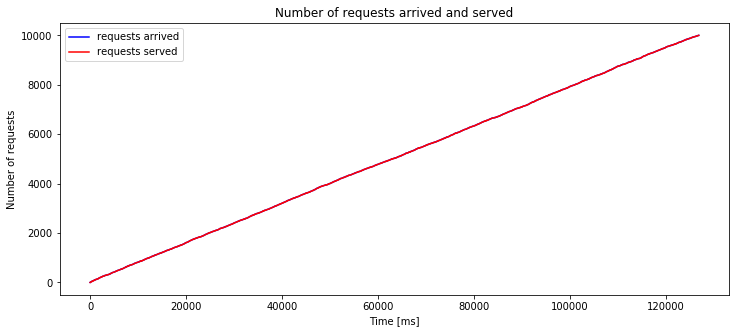

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

x0, y0 = list(zip(*history_num_job_arrived))
x1, y1 = list(zip(*history_num_job_served))

ax.step(x0, y0, c='b', label='requests arrived')
ax.step(x1, y1, c='r', label='requests served')
ax.set_title('Number of requests arrived and served')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Number of requests')
plt.legend()
plt.savefig('q1_req.png', dpi=300)

In [10]:
buffer_t1

[(0.1307795974986063, 1),
 (0.1307795974986063, 0),
 (7.859533011540059, 1),
 (9.028106167054673, 2),
 (10.0574123444632, 1),
 (12.855138765147291, 0),
 (35.26516874501279, 1),
 (35.26516874501279, 0),
 (44.615214434086035, 1),
 (44.615214434086035, 0),
 (45.640807598835, 1),
 (46.20557780306814, 0),
 (53.79931228916675, 1),
 (56.694961588186466, 2),
 (60.459764275411814, 1),
 (64.13084937246073, 2),
 (64.6730431336706, 1),
 (67.70059529421536, 0),
 (73.17043373895089, 1),
 (77.06687501622181, 0),
 (81.759080742982, 1),
 (83.61218955788266, 0),
 (87.72871850293933, 1),
 (89.601942419138, 0),
 (92.41028404006049, 1),
 (93.60993586362655, 2),
 (93.70343186061012, 1),
 (101.98884592480135, 0),
 (118.99630251671311, 1),
 (118.99630251671311, 0),
 (128.69187813270818, 1),
 (128.69187813270818, 0),
 (163.111333588792, 1),
 (163.111333588792, 0),
 (175.8159133118877, 1),
 (175.8159133118877, 0),
 (191.18876509648135, 1),
 (191.18876509648135, 0),
 (194.77318623812516, 1),
 (197.1120387592462,

In [124]:
times, count = list(zip(*buffer_t2))

np.mean(np.array(count))

np.max(count)

8

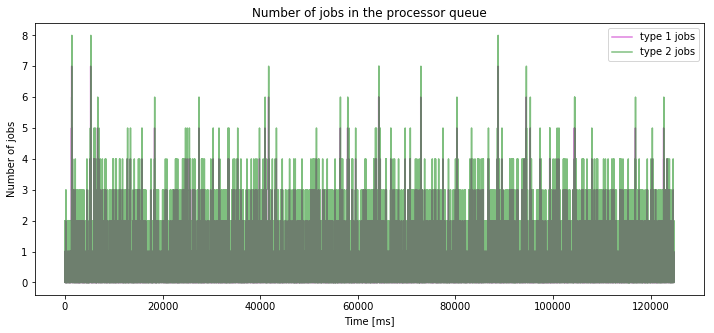

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

x0, y0 = list(zip(*buffer_t1))
x1, y1 = list(zip(*buffer_t2))

ax.step(x0, y0, c='m', label='type 1 jobs', alpha=0.5)
ax.step(x1, y1, c='g', label='type 2 jobs', alpha=0.5)
ax.set_title('Number of jobs in the processor queue')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Number of jobs')
plt.legend()
#plt.savefig('q1_job.png', dpi=300)

In [7]:
print('Average response time for type 1 job: {:.3f}'.format(art_1))
print('Average response time for type 2 job: {:.3f}'.format(art_2))

Average response time for type 1 job: 8.928
Average response time for type 2 job: 5.186


In [8]:
average_response_time_request = (art_1 + art_2) / 1000
print('Average number of type 1 job served per second: {:.3f}'.format(1/average_response_time_request))
print('Average number of type 2 job served per second: {:.3f}'.format(1/average_response_time_request))

Average number of type 1 job served per second: 70.855
Average number of type 2 job served per second: 70.855


## Question 2 

In [85]:

def jobs_per_lambda(lambda_):
    
    server = Server(max_req=10000, arrival_rate=lambda_/1000)
    history_num_job_arrived, history_num_job_served, buffer_t1, buffer_t2, art_1, art_2 = server.run()
    
    
    events = server.buffer.copy()
    events.sort(key= lambda triple: triple[1])
    jobs_at_time = []
    job_count = 0
    for(type_of_job, time, operation) in events:
        if(operation == 1 ): 
            job_count+=1 
        else: job_count-=1
        jobs_at_time.append((time, job_count))
        
    times, jobs = list(zip(*jobs_at_time))
    times = list(times)
    jobs =  list(jobs)
    
    
    return (times, jobs)


In [88]:
lambda_ = [30, 60, 90, 120, 150, 180, 210, 250]

time_jobs = []
for rate in lambda_:
    time_jobs.append(jobs_per_lambda(rate))
    
#save points so we can always reuse the same
np.save('time_jobs', np.array(time_jobs))

30
60
90
120
150
180
210
250


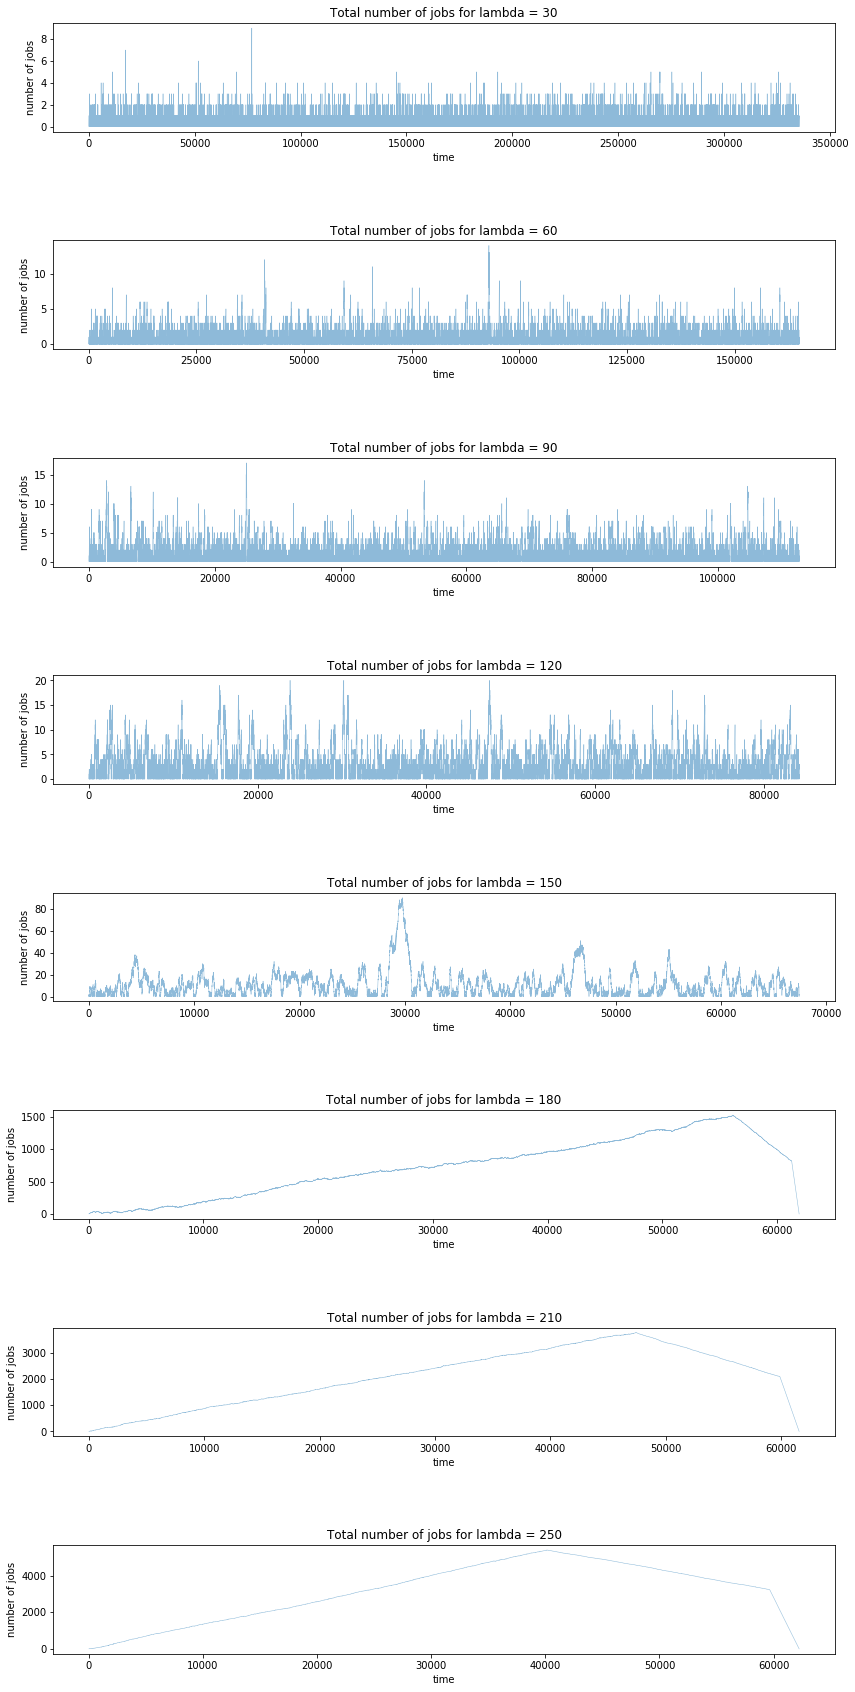

In [118]:
fig, ax = plt.subplots(8, 1, figsize=(14,30))

plt.subplots_adjust(hspace = 1.0)
i = 0 
for (i, time_job_rate) in enumerate(list(zip(time_jobs,lambda_))):


    rate = time_job_rate[1]
    time = time_job_rate[0][0]
    job_count = time_job_rate[0][1]

    
    ax[i].scatter(time, job_count, marker='.', alpha= 0)
    ax[i].plot(time, job_count, linewidth=0.5, alpha=0.5) 
    ax[i].set_title("Total number of jobs for lambda = " + str(rate),)
    ax[i].set_xlabel("time")
    ax[i].set_ylabel("number of jobs")

    

    
    

## Question 3 

Code reuse from previous lab

In [133]:
def calculate_mean_std(data, MLE_std=True):
    n = len(data)
    mean = np.mean(data)
    if MLE_std:
        n -=1
    
    acc = 0
    
    for value in data:
        res = math.pow((value-mean),2)
        acc += res
    std = math.sqrt(acc/n)
    return mean, std

Code reuse of previous lab

In [134]:
def CI_median_normal(data):
    n = len(data)
    data_sort = np.sort(data)
    j = 0
    k = 0
    if (n == 30):
        # read from the exam booklet
        j = 10-1
        k = 21-1
    elif (n>70):
        j = math.floor(0.5 * n - 0.980 * math.sqrt(n)) - 1
        k = math.ceil(0.5 * n + 1 + 0.980 * math.sqrt(n)) - 1
    else:
        print('Rules are only defined for N=30 and N>70.')
    return data_sort[j], data_sort[k], np.median(data)

In [135]:
def CI_mean_asymptotic_for_95(data):
    n = len(data)
    mean, std = calculate_mean_std(data,False) 
    U = mean + (1.96*std)/math.sqrt(n)
    L = mean - (1.96*std)/math.sqrt(n)
    
    return L, U, mean

In [197]:
def get_CI_mean_median_t1_t2(lambda_, n=30):

    n = 30

    avg_type1_jobs = []
    avg_type2_jobs = []

    for i in range(n):
        history_num_job_arrived, history_num_job_served, buffer_t1, buffer_t2, art_1, art_2 = Server(max_req=10000, arrival_rate=lambda_/1000).run()

        times_t1, count_t1 = list(zip(*buffer_t1))
        times_t2, count_t2 = list(zip(*buffer_t2))

        mean_t1 = np.mean(np.array(count_t1))
        mean_t2 = np.mean(np.array(count_t2))

        avg_type1_jobs.append((mean_t1))
        avg_type2_jobs.append((mean_t2))
        
    return (CI_mean_asymptotic_for_95(avg_type1_jobs), 
            CI_mean_asymptotic_for_95(avg_type2_jobs),
            CI_median_normal(avg_type1_jobs),
            CI_median_normal(avg_type2_jobs))



Code reuse of previous lab

In [198]:
def plot_CI(x_label, y_label, name, n, type_CI_mean, type_CI_median,top,bottom ):
    fig, ax = plt.subplots(1, 1, figsize=(2,10))
    
    L_mean, U_mean, mean =  type_CI_mean
    L_median, U_median, median = type_CI_median

    print("Calculated mean:   {:.5f}".format(mean))
    print("Calculated median: {:.5f}".format(median))
    print("Confidence interval of mean: [{:.5f},{:.5f}]".format(L_mean, U_mean))
    print("Confidence interval of median: [{:.5f},{:.5f}]".format(L_median, U_median)) 
    print("Width size of mean: {:.5f}".format(U_mean - L_mean))
    print("Width size of median: {:.5f}".format(U_median - L_median))
        
    # horizontal lines
    ax.axhline(y=L_mean, linestyle='--', color='b', linewidth=1)
    ax.axhline(y=U_mean, linestyle='--', color='b', linewidth=1)
    ax.axhline(y=L_median, linestyle='--', color='r', linewidth=1)
    ax.axhline(y=U_median, linestyle='--', color='r', linewidth=1)
    
    # vertical lines
    l1 = mlines.Line2D([0.2], [L_mean, U_mean], color='b', linestyle='-', linewidth=1)
    l2 = mlines.Line2D([0.8], [L_median, U_median], color='r', linestyle='-', linewidth=1)
    ax.add_line(l1)
    ax.add_line(l2)
    
    # mean and median markers
    ax.plot([0.2],[mean], marker='o', color='b', markersize=5) 
    ax.plot([0.8],[median], marker= 'o', color='r', markersize=5)
    
    # trick to make nicer plot
    ax.plot([0],[mean], marker='o', alpha=0) 
    ax.plot([1],[median], marker= 'o', alpha=0)

    ax.set_title('CI (N={})'.format(str(n)))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(bottom=bottom, top=top)
    plt.xticks([0.2,0.8], ['Mean', 'Median'])
    plt.locator_params(axis='y', nbins=20)
    plt.savefig(name+'.png', dpi=300, bbox_inches='tight')

In [199]:
type1_CI_mean, type2_CI_mean, type1_CI_med, type2_CI_med = get_CI_mean_median_t1_t2(30)

Calculated mean:   0.52236
Calculated median: 0.52245
Confidence interval of mean: [0.52167,0.52305]
Confidence interval of median: [0.52170,0.52320]
Width size of mean: 0.00138
Width size of median: 0.00150


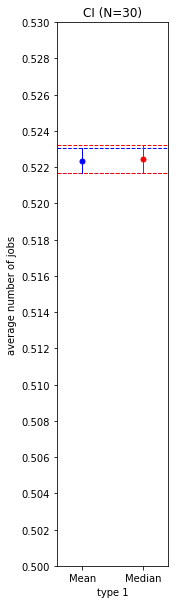

In [204]:
plot_CI("type 1", "average number of jobs", "q3_type1_CI_plot_with_transient_lambda30", 30,  type1_CI_mean, type1_CI_med, 0.53,0.5)

In [ ]:
type1_CI_mean, type2_CI_mean, type1_CI_med, type2_CI_med = get_CI_mean_median_t1_t2(160)

Calculated mean:   28.35929
Calculated median: 25.19010
Confidence interval of mean: [24.38258,32.33600]
Confidence interval of median: [20.57600,31.04120]
Width size of mean: 7.95342
Width size of median: 10.46520


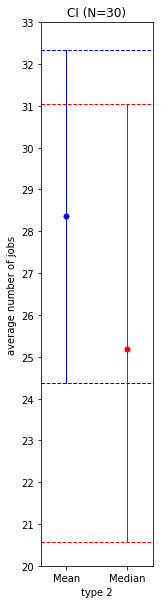

In [207]:
plot_CI("type 2", "average number of jobs", "q3_type2_CI_plot_with_transient_lambda30", 30,  type2_CI_mean, type2_CI_med, 33, 20)

In [205]:
type1_CI_mean, type2_CI_mean, type1_CI_med, type2_CI_med = get_CI_mean_median_t1_t2(160)

In [195]:
type1_CI_mean

(0.623842261115127, 0.6295310722182063, 0.6266866666666666)